Note: you may need to restart the kernel to use updated packages.


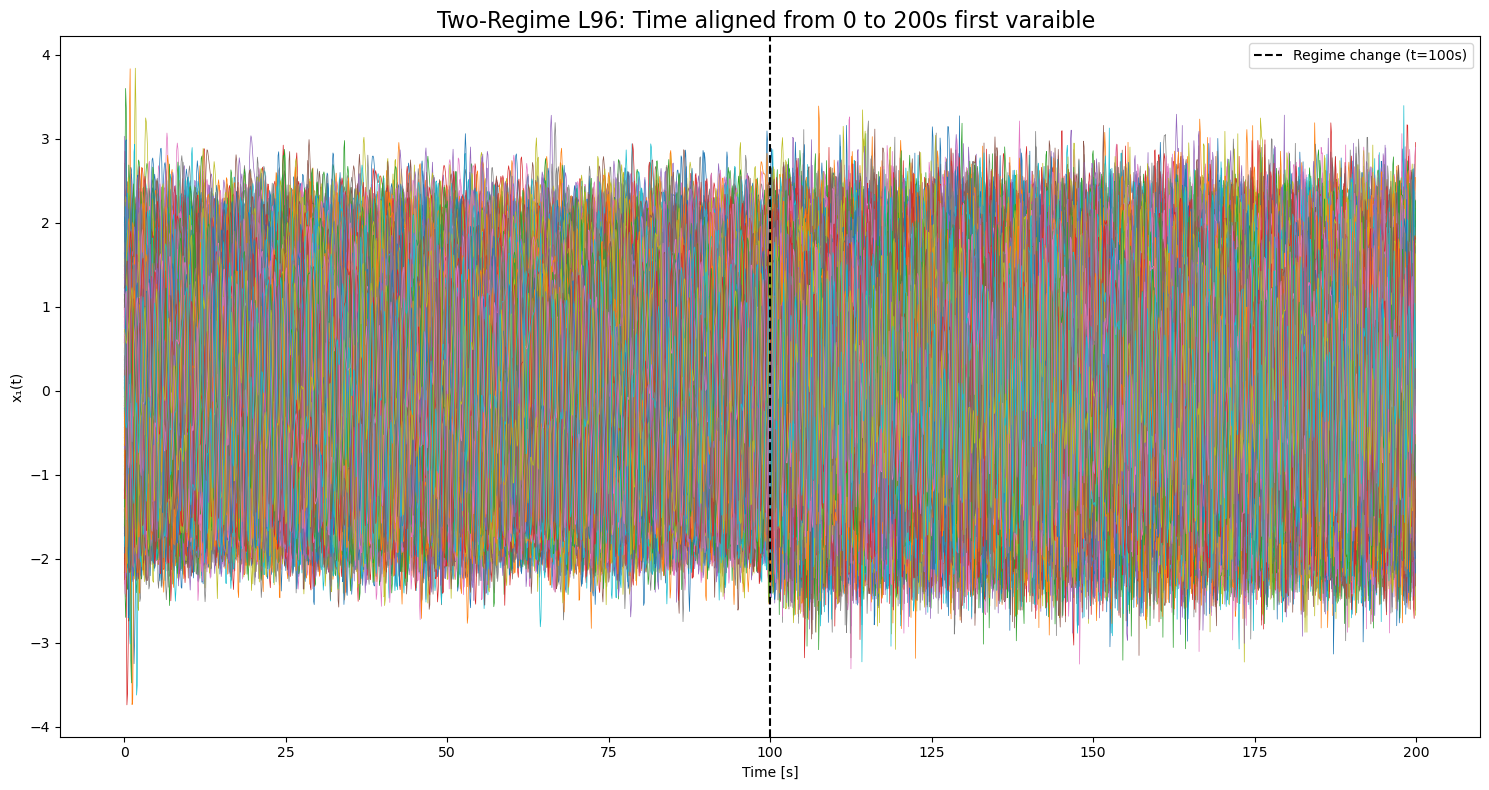

(540, 2000)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
%pip install pydmd
from pydmd import DMD, BOPDMD, MrDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing
import warnings
from sklearn.preprocessing import StandardScaler
import CustomRQA as rqa
import truncate as tr
warnings.filterwarnings('ignore')

def l96(x,t, F, alpha=1):
  return (np.roll(x, -1) - np.roll(x, 2)) * np.roll(x, 1) - alpha* x + F
total_time = 120
m = 1200
dt = total_time/m
t1 = np.arange(0.0,total_time, dt)
n=540
F_1 = 5
x0 = F_1 * np.ones(n)
x0[0] += 0.01
alpha1=1
regime1 = odeint(l96, x0, t1, args=(F_1, alpha1))
regime1 = regime1[200:]
t1 = t1[200:]
total_time = 200
m = 2000
dt = total_time/m
t2 = np.arange(0.0,total_time, dt)
F_2 = 16
x0 = F_2 * np.ones(n)
x0[0] += 0.01
alpha2= 1.5
regime2 = odeint(l96, x0, t2, args=(F_2, alpha2))
regime2 = regime2[1000:]
t2 = t2[1000:]
t1_adj = (t1 - 20)     
t2_adj = t2     

t = np.concatenate([t1_adj, t2_adj])              
x = np.vstack([regime1, regime2])              
X = x.T
X = StandardScaler().fit_transform(X)
plt.figure(figsize=(15,8))
for i in range(540):
    plt.plot(t, X[i], lw=0.5)
plt.axvline(100, color='k', linestyle='--', label='Regime change (t=100s)')
plt.xlabel('Time [s]')
plt.ylabel('x₁(t)')
plt.title('Two‐Regime L96: Time aligned from 0 to 200s first varaible ', fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()
print(X.shape)

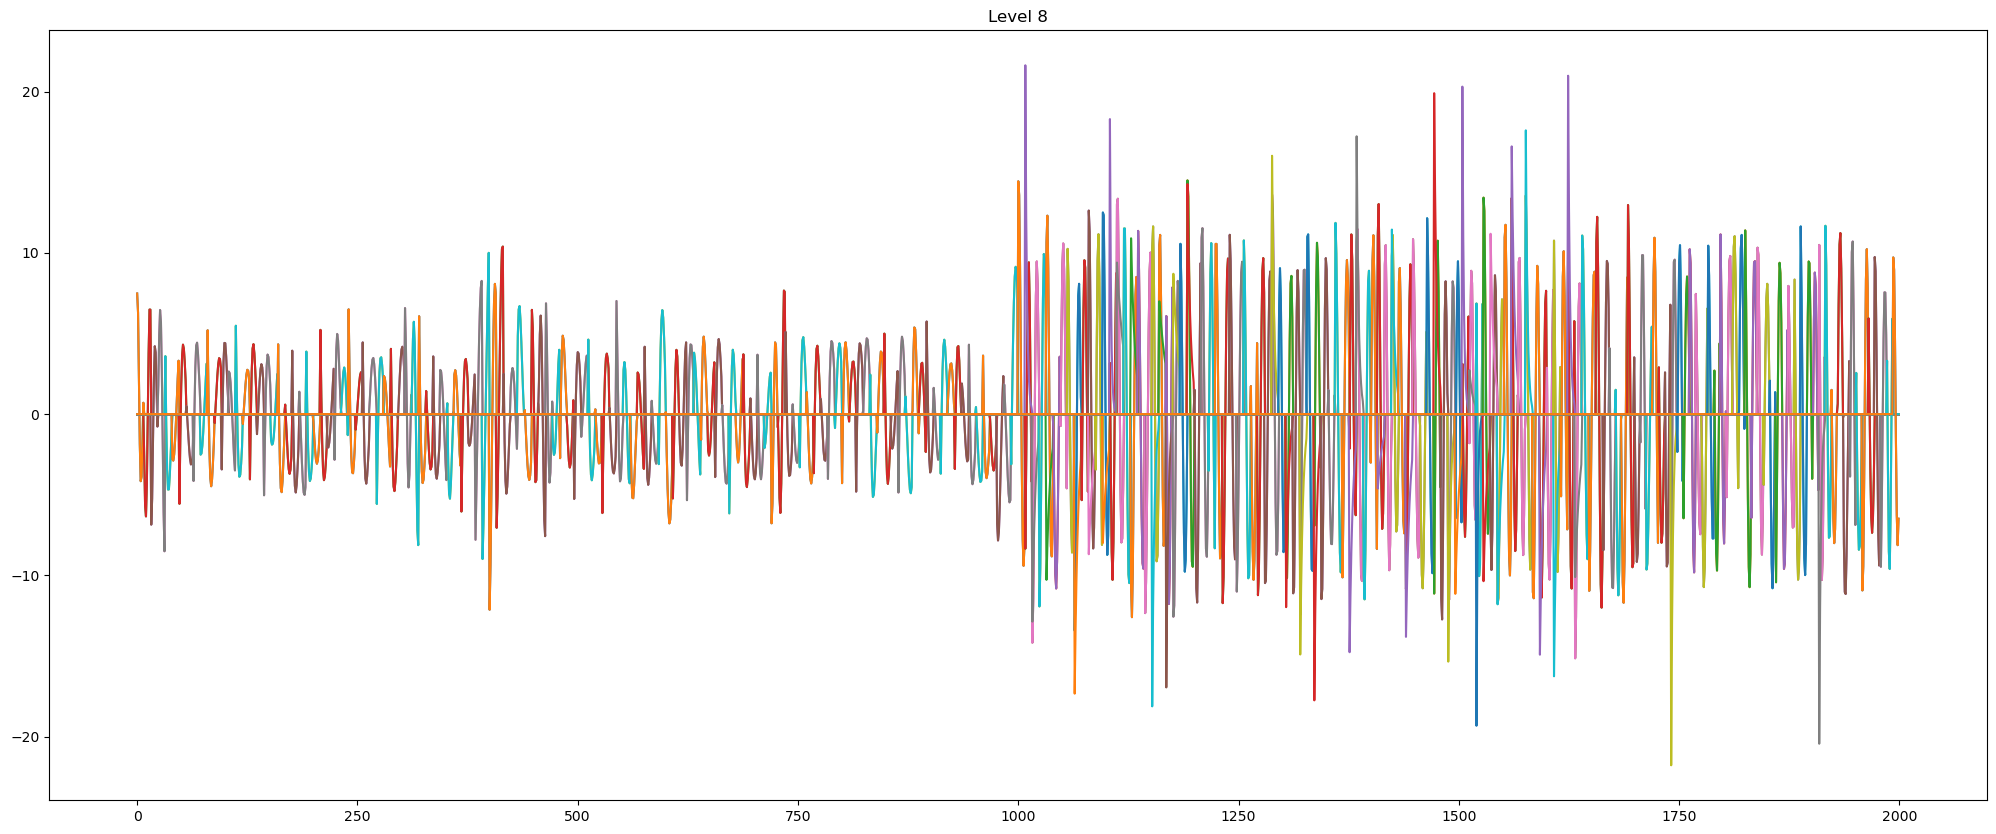

(552, 2000)


In [2]:
sub_dmd = DMD(svd_rank=0.75)
l=8
mrdmd = MrDMD(sub_dmd, max_level=l, max_cycles=1)
mrdmd.fit(X)
for j in range(l,l+1):
    last_dynamics = mrdmd.partial_dynamics(level=j)
    plt.figure(figsize=(25,10))
    for i in range(last_dynamics.shape[0]):
        plt.plot(last_dynamics[i])
    plt.title(f'Level {j}')
    plt.show()
print(last_dynamics.shape)

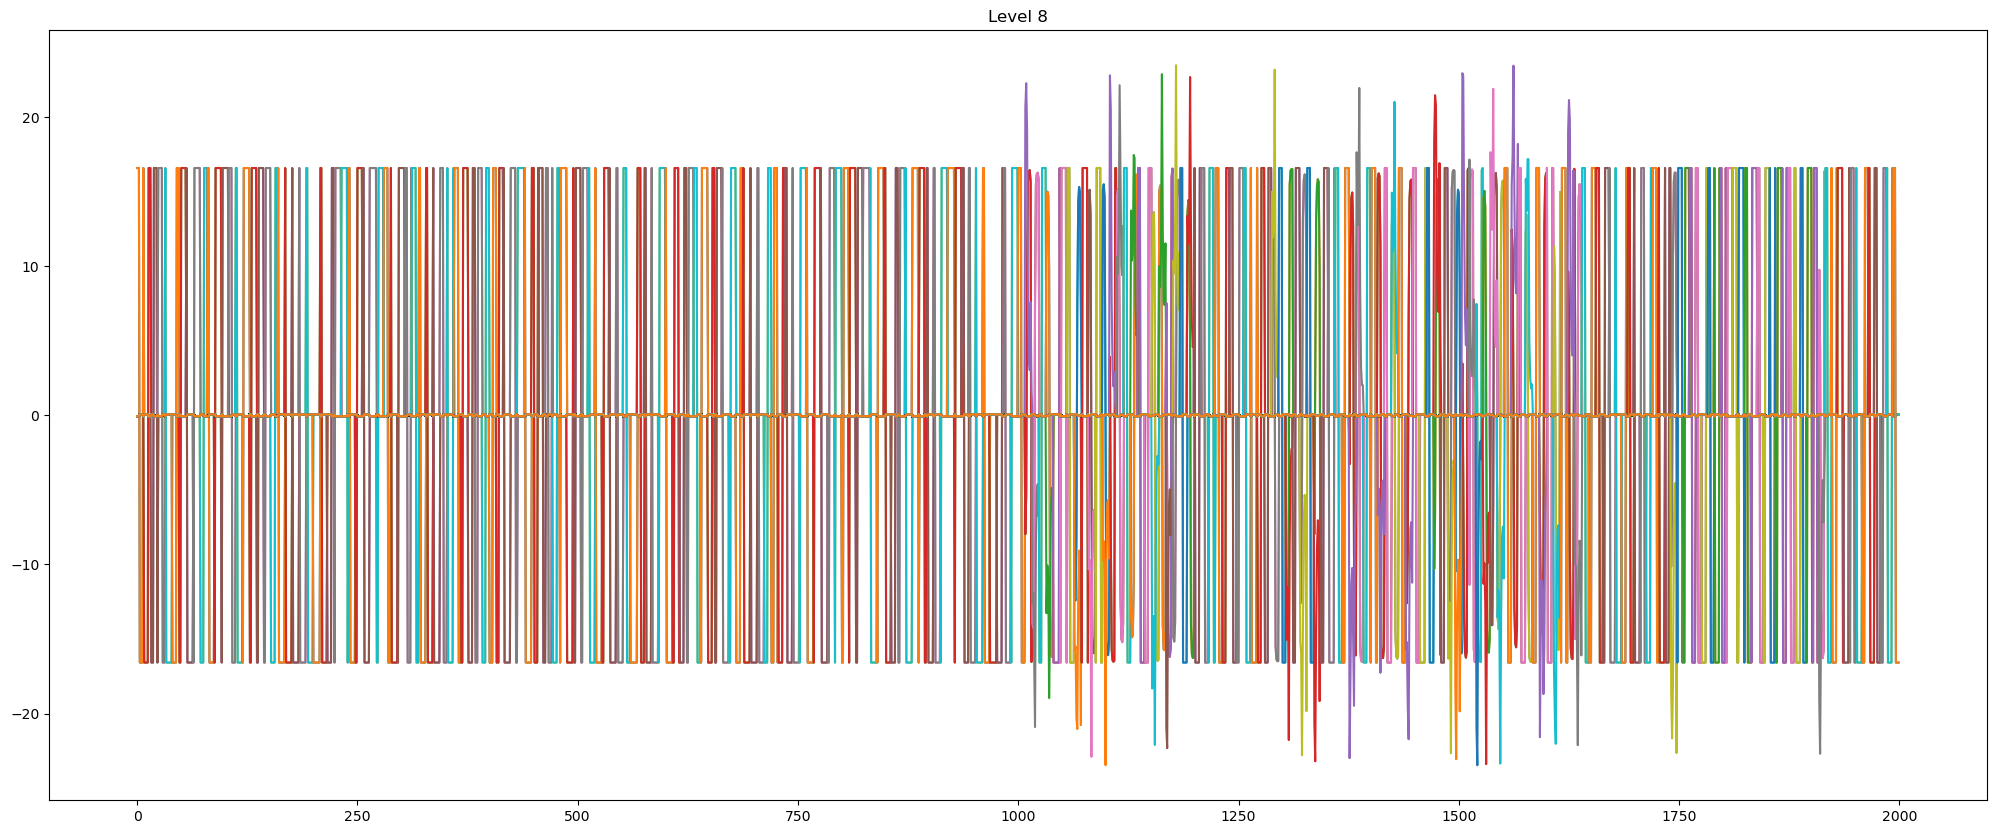

In [3]:
last_dynamics = StandardScaler().fit_transform(last_dynamics.real)
plt.figure(figsize=(25,10))
for i in range(last_dynamics.shape[0]):
    plt.plot(last_dynamics[i])
plt.title(f'Level {j}')
plt.show()

In [4]:
print(last_dynamics.shape)
df_dynamics = tr.correlation_truncate(last_dynamics.T, threshold =0.80)
all_vectors_new = df_dynamics.to_numpy()
all_vectors = all_vectors_new
print(all_vectors_new.shape)

all_vectors = all_vectors_new
p=10

(552, 2000)
(2000, 296)


epsilon = 23.458


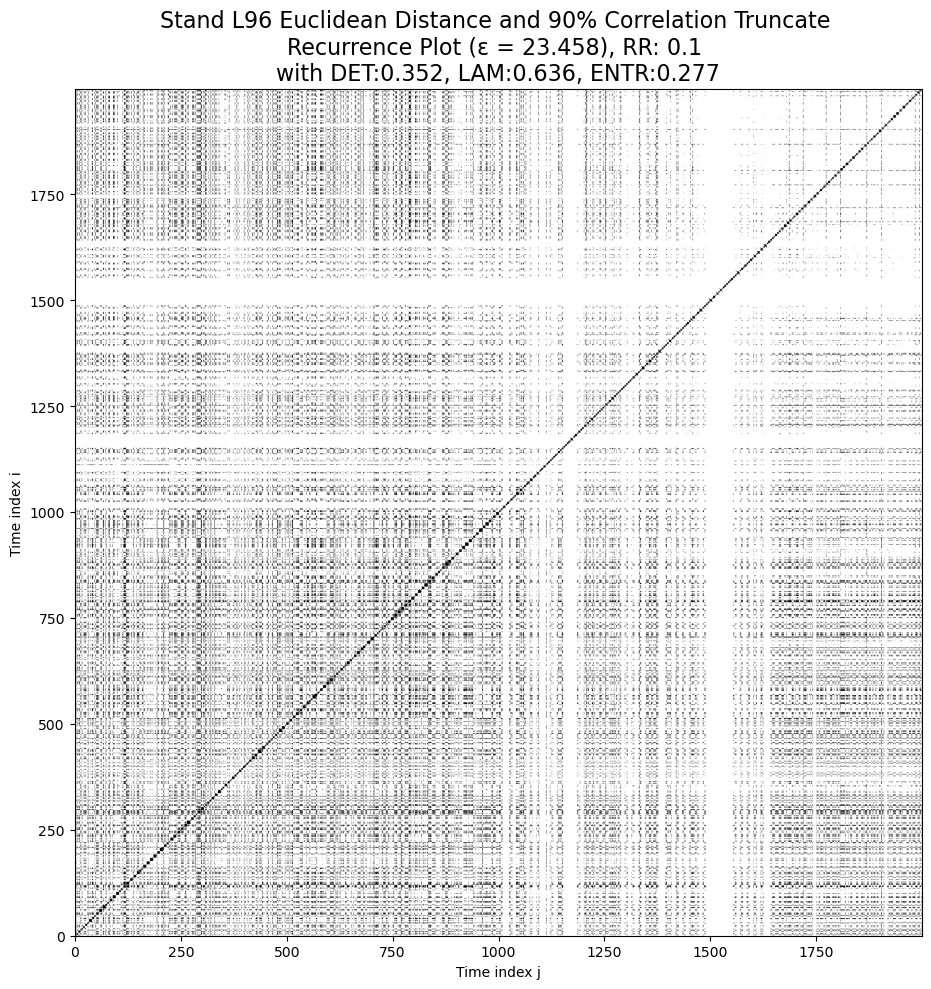

In [5]:
metrics = rqa.RecurrencePlot(all_vectors, percent=p, metric ='euclidean', globalEpsilon=True, Title = 'Stand L96 Euclidean Distance and 90% Correlation Truncate',lines = False)

In [6]:
dt = 0.1                  
window_size = int(0.2 * all_vectors.shape[0])
#window_size = 50           
times, DETS, LAMS, ENTRS = rqa.sliding_window_rqa(all_vectors, p, metric='euclidean', q=1, window_size=window_size, step=1, l_min=2, v_min=2, globalEpsilon=True)


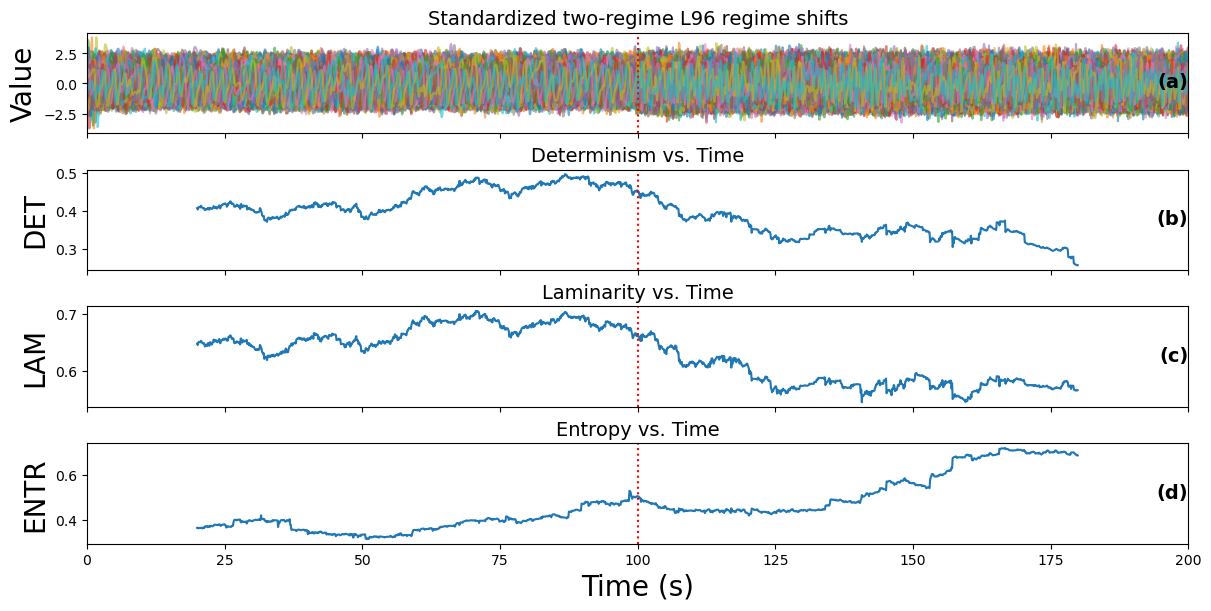

In [7]:
real_times = times * dt
total_time = X.shape[1] * dt
time_axis = np.arange(X.shape[1]) * dt

regime_times = [100]
regime_kwargs = dict(color='red', linestyle='dotted')

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 6), constrained_layout=True)
labels = ['(a)', '(b)', '(c)', '(d)']

for row in X:
    axes[0].plot(time_axis, row, alpha=0.6)
axes[0].set_ylabel('Value', fontsize=20)
axes[0].set_title('Standardized two‐regime L96 regime shifts', fontsize=14)
for t in regime_times:
    axes[0].axvline(t, **regime_kwargs)
axes[0].text(1, 0.51, labels[0],transform=axes[0].transAxes,fontsize=14, fontweight='bold',ha='right', va='center')

# DET
axes[1].plot(real_times, DETS)
axes[1].set_ylabel('DET', fontsize=20)
axes[1].set_title('Determinism vs. Time', fontsize=14)
for t in regime_times:
    axes[1].axvline(t, **regime_kwargs)
axes[1].text(1, 0.51, labels[1],transform=axes[1].transAxes,fontsize=14, fontweight='bold',ha='right', va='center')

# LAM
axes[2].plot(real_times, LAMS)
axes[2].set_ylabel('LAM', fontsize=20)
axes[2].set_title('Laminarity vs. Time', fontsize=14)
for t in regime_times:
    axes[2].axvline(t, **regime_kwargs)
axes[2].text(1, 0.51, labels[2],transform=axes[2].transAxes, fontsize=14, fontweight='bold',ha='right', va='center')

# ENTR
axes[3].plot(real_times, ENTRS)
axes[3].set_ylabel('ENTR', fontsize=20)
axes[3].set_title('Entropy vs. Time', fontsize=14)
for t in regime_times:
    axes[3].axvline(t, **regime_kwargs)
axes[3].text(1, 0.51, labels[3], transform=axes[3].transAxes, fontsize=14, fontweight='bold', ha='right', va='center')

axes[3].set_xlabel('Time (s)', fontsize=20)
axes[3].set_xlim(0, total_time)

plt.show()